### Data Cleaning

In [124]:
!pip install fancyimpute


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/45/50/f28f45a75e25811d433a34d1d6c88715961041963750fc1cab45f9583596/cvxpy-1.4.3-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for cvxopt from https://files.pythonhosted.org/packages/74/0f/297db0387cc75ea2370d360d62853826d1ddf92e1729fd48ca11d7bb1e53/cvxopt-1.3.2-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for osqp>=0.6.2 from https://files.pythonhosted.org/packages/06/2f/9a9e0797dde5ca183449a3776ee05ac06b12b69385f4d9d862fb816124f1/osqp-0.6.5-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for ecos>=2 from https://files.pythonhosted.org/packages/4c/58/17cf7402da41f796fb4a35ac3d419431b3321a3963311d782651ad0252cf/ecos-2.0.13-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for clarabel>=0.5.0 from https

    Uninstalling scipy-1.12.0:
      Successfully uninstalled scipy-1.12.0

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [205]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer


##### Import data

In [210]:
dfmain = pd.read_csv('/Users/veg/Desktop/Most-Recent-Cohorts-Institution.csv', low_memory=False)

In [211]:
dfmain.shape

(6543, 3232)

In [214]:
df_raw = dfmain[[
    'HIGHDEG',  # Highest Degree Offered
    'ICLEVEL',  # Level of Institution (4-year, 2-year, less-than-2-year)
    'SAT_AVG_ALL',  # Average SAT score across all campuses
    'ADM_RATE_ALL',  # Admission rate across all campuses
    'TUITFTE',  # Net tuition revenue per FTE student
    'CONTROL',  # Control of institution (public, private nonprofit, private for-profit)
    'GRAD_DEBT_MDN',  # Median debt for students who have completed
    'COMP_ORIG_YR4_RT',  # Percent completed within 4 years at original institution
    'PCTFLOAN',  # Percent of undergrad students receiving federal student loan
    'MD_EARN_WNE_P8',  # Median earnings of students working and not enrolled 8 years after entry
    'CDR3',  # Three-year cohort default rate
    'DEP_INC_AVG',  # Average family income of dependent students
    'UG25ABV',  # Percentage of undergraduates aged 25 and above
    'UGDS',  # Enrollment of undergraduate certificate/degree-seeking students
    'COSTT4_A',  # Average cost of attendance (academic year institutions)
    'COSTT4_P',  # Average cost of attendance (program-year institutions)
    'PAR_ED_PCT_PS',  # Percent of students whose parents' highest education level is some postsecondary education
    'RPY_3YR_RT' #Predict value
]]

df.shape

(6217, 17)

In [243]:
df_raw.isnull().sum()

HIGHDEG                0
ICLEVEL                0
SAT_AVG_ALL         5371
ADM_RATE_ALL        4319
TUITFTE              519
CONTROL                0
GRAD_DEBT_MDN       1514
COMP_ORIG_YR4_RT    1353
PCTFLOAN             805
MD_EARN_WNE_P8      1153
CDR3                 870
DEP_INC_AVG          987
UG25ABV              871
UGDS                 774
PAR_ED_PCT_PS       1279
RPY_3YR_RT          1508
ATDCOST             1248
dtype: int64

##### Data Cleaning

In [215]:
# COST
df_raw['COSTT4_A'] = pd.to_numeric(df_raw['COSTT4_A'], errors='coerce')
df_raw['COSTT4_P'] = pd.to_numeric(df_raw['COSTT4_P'], errors='coerce')
# if one cost feature is missing and the other is present, the missing value should be zero because the institution type would have only one kind of cost
df_raw.loc[df_raw['COSTT4_A'].isna() & df_raw['COSTT4_P'].notna(), 'COSTT4_A'] = 0
df_raw.loc[df_raw['COSTT4_P'].isna() & df_raw['COSTT4_A'].notna(), 'COSTT4_P'] = 0
df_raw['ATDCOST'] = df_raw['COSTT4_A'] + df_raw['COSTT4_P']
df_raw.drop(['COSTT4_A', 'COSTT4_P'], axis=1, inplace=True)

# other columns
columns_to_convert = ['GRAD_DEBT_MDN', 'COMP_ORIG_YR4_RT', 'DEP_INC_AVG', 'PAR_ED_PCT_PS', 'RPY_3YR_RT']
for column in columns_to_convert:
    df_raw[column] = pd.to_numeric(df_raw[column], errors='coerce')


# Handle missing value: IterativeImputer
df = df_raw.copy()
mice_imputer = IterativeImputer()
df[df.columns] = mice_imputer.fit_transform(df)

df = df.drop_duplicates()

print(df.info())

/var/folders/sb/nn5xh9296w97kmbvt47753b80000gn/T/ipykernel_17922/3533716167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['COSTT4_A'] = pd.to_numeric(df_raw['COSTT4_A'], errors='coerce')
/var/folders/sb/nn5xh9296w97kmbvt47753b80000gn/T/ipykernel_17922/3533716167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['COSTT4_P'] = pd.to_numeric(df_raw['COSTT4_P'], errors='coerce')
/var/folders/sb/nn5xh9296w97kmbvt47753b80000gn/T/ipykernel_17922/3533716167.py:7: SettingWithCopyWarning: 
A val

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6217 entries, 0 to 6542
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HIGHDEG           6217 non-null   float64
 1   ICLEVEL           6217 non-null   float64
 2   SAT_AVG_ALL       6217 non-null   float64
 3   ADM_RATE_ALL      6217 non-null   float64
 4   TUITFTE           6217 non-null   float64
 5   CONTROL           6217 non-null   float64
 6   GRAD_DEBT_MDN     6217 non-null   float64
 7   COMP_ORIG_YR4_RT  6217 non-null   float64
 8   PCTFLOAN          6217 non-null   float64
 9   MD_EARN_WNE_P8    6217 non-null   float64
 10  CDR3              6217 non-null   float64
 11  DEP_INC_AVG       6217 non-null   float64
 12  UG25ABV           6217 non-null   float64
 13  UGDS              6217 non-null   float64
 14  PAR_ED_PCT_PS     6217 non-null   float64
 15  RPY_3YR_RT        6217 non-null   float64
 16  ATDCOST           6217 non-null   float64


/Users/veg/opt/anaconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Text(0, 0.5, 'Frequency')

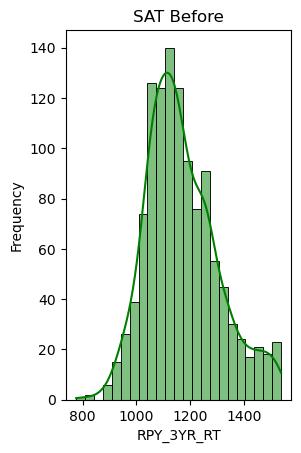

In [241]:
plt.subplot(1, 2, 2)
sns.histplot(df_raw['SAT_AVG_ALL'], kde=True, color='green', label='Imputed')
plt.title('SAT Before')
plt.xlabel(column)
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

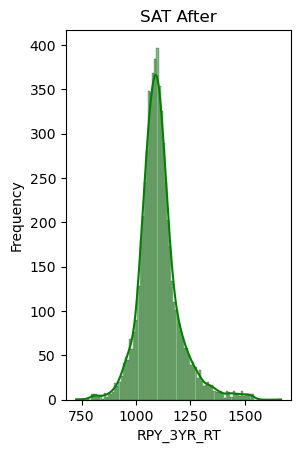

In [242]:
plt.subplot(1, 2, 2)
sns.histplot(df['SAT_AVG_ALL'], kde=True, color='green', label='Imputed')
plt.title('SAT After')
plt.xlabel(column)
plt.ylabel('Frequency')

##### Feature Selection

##### 1) Correlation Plot

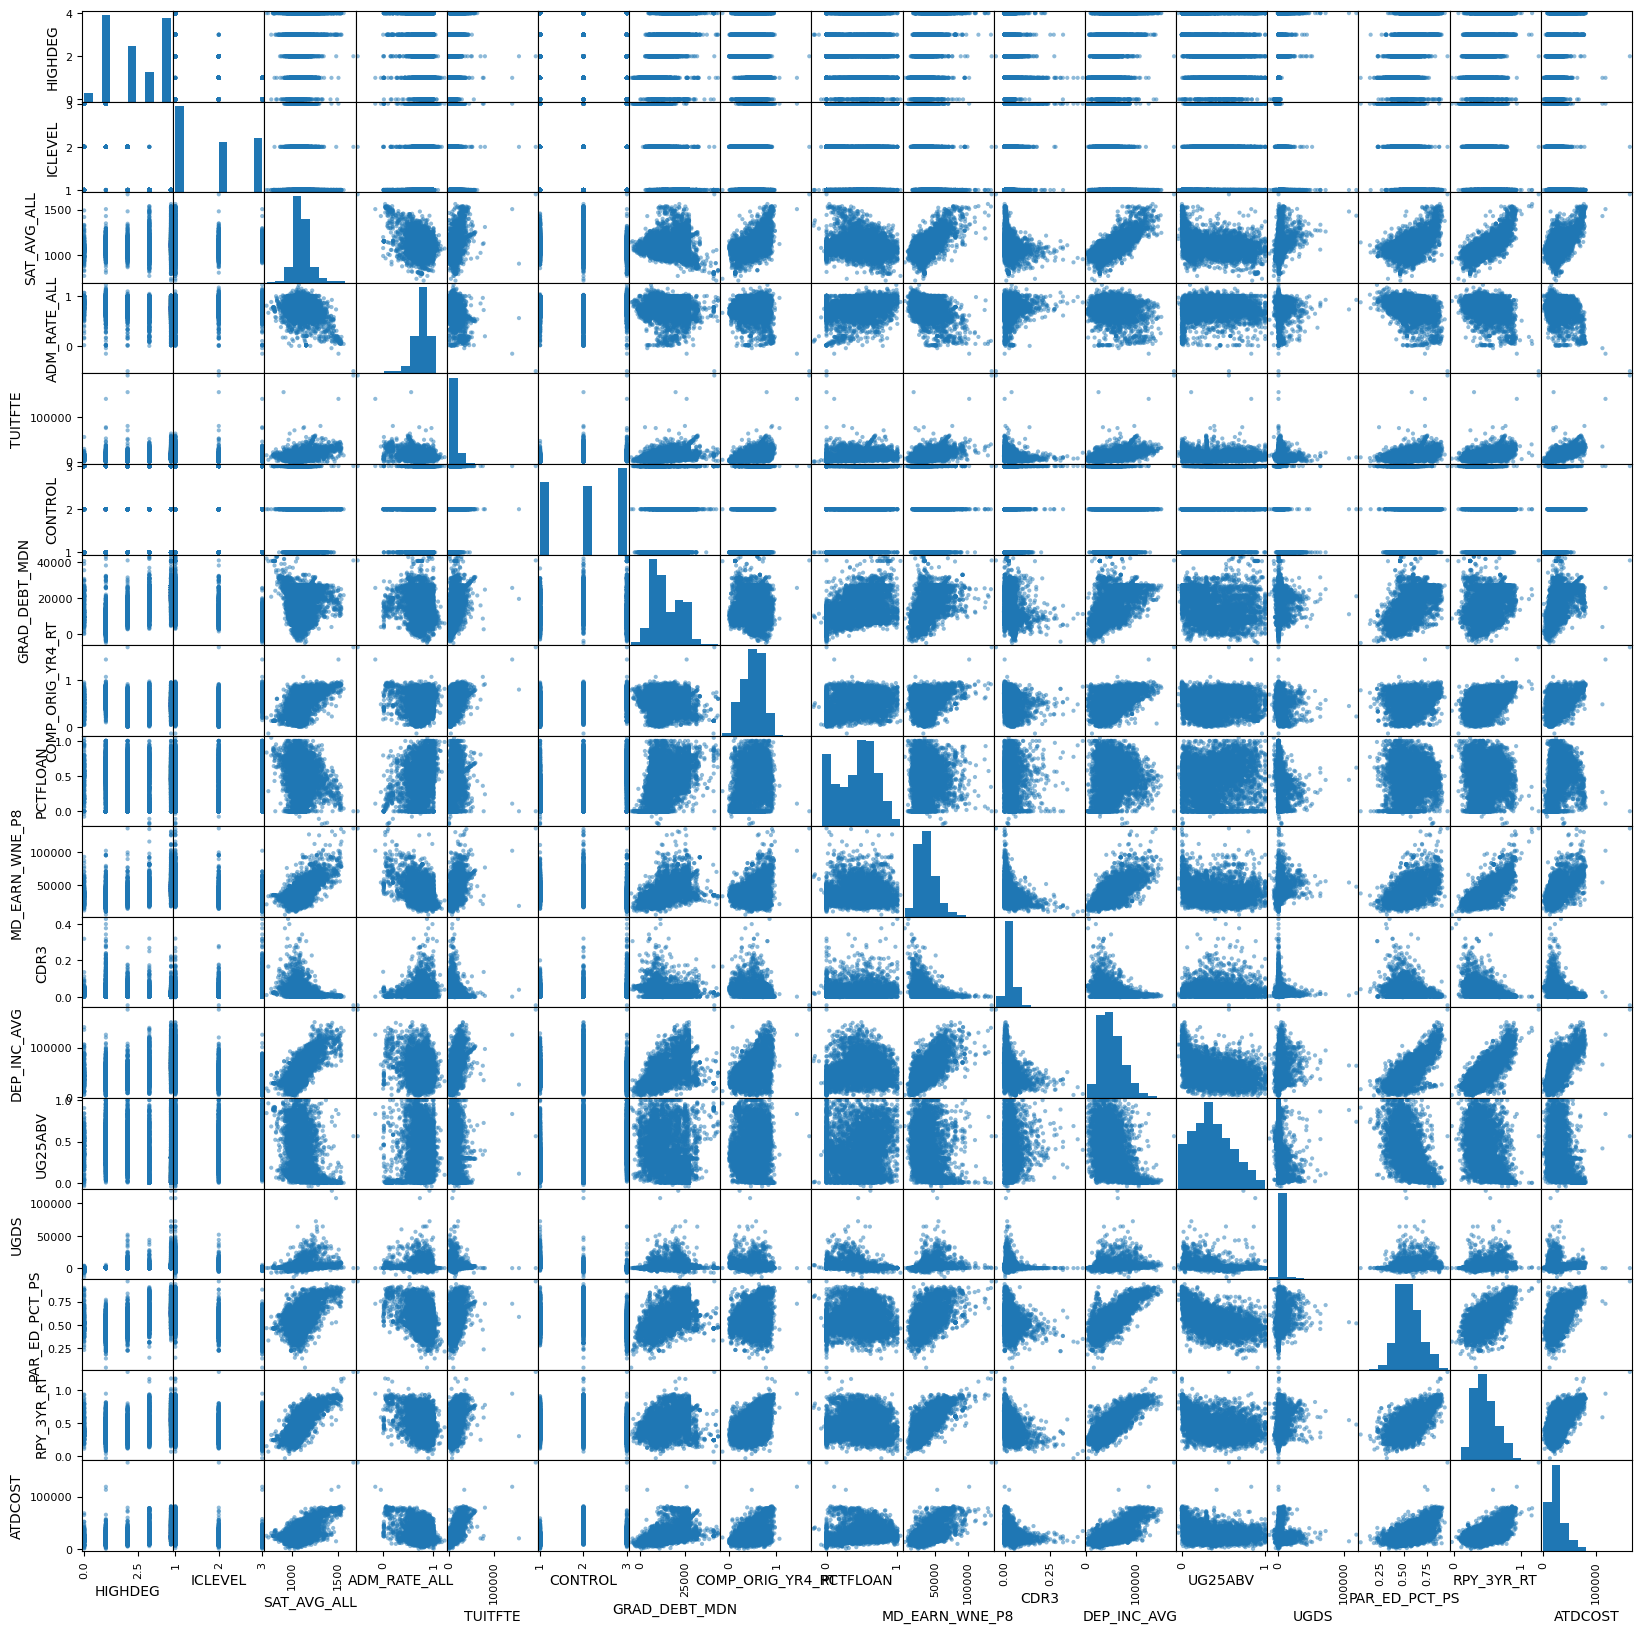

In [218]:
pd.plotting.scatter_matrix(df, figsize=(20,20))
plt.show()

##### 2) Heatmap

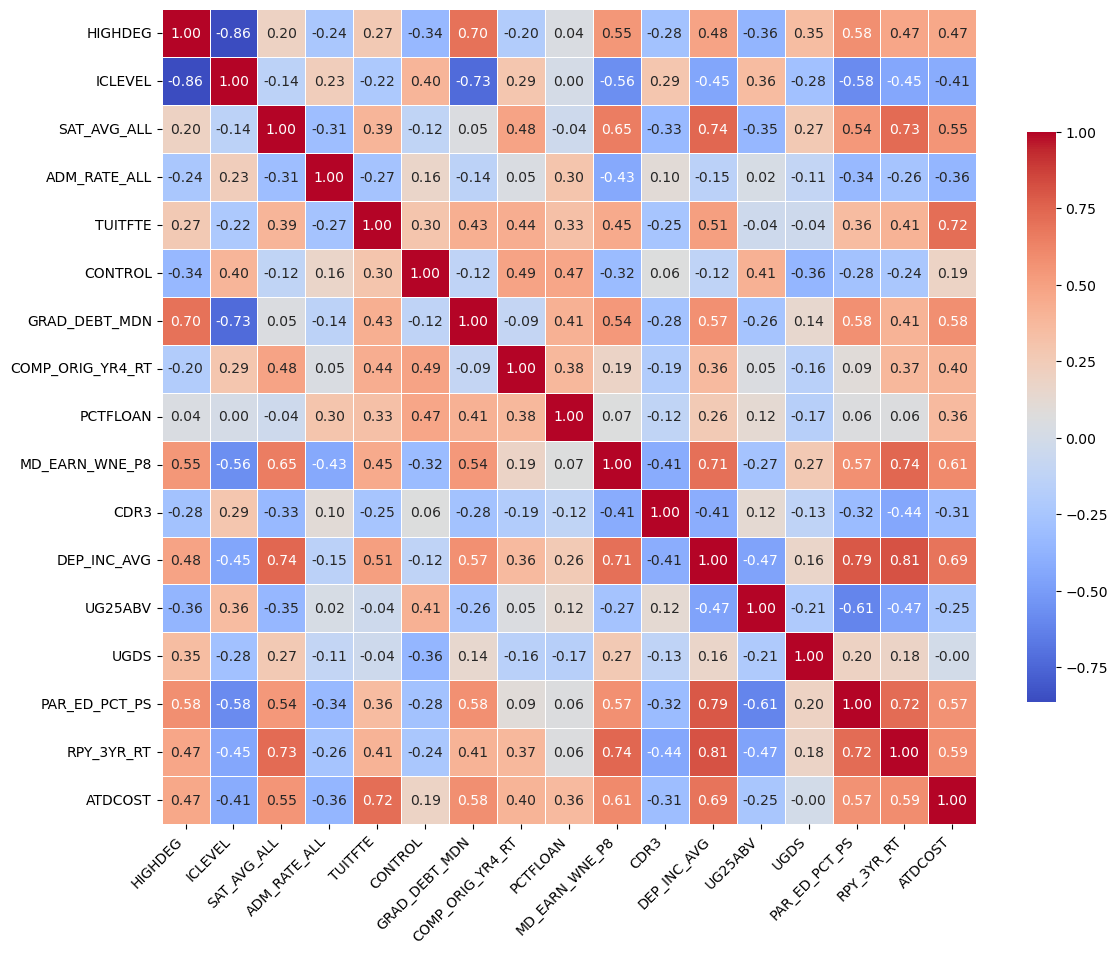

In [219]:
corr = df.corr()
plt.figure(figsize=(12, 12))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  
plt.show()

##### 3) Linear Model

In [220]:
X = df.drop(['RPY_3YR_RT'], axis=1)
X_cons = sm.add_constant(X) 
y = df['RPY_3YR_RT']

In [221]:
model = sm.OLS(y, X_cons, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             RPY_3YR_RT   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1559.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:55:07   Log-Likelihood:                 7235.8
No. Observations:                6217   AIC:                        -1.444e+04
Df Residuals:                    6200   BIC:                        -1.432e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0511      0.038  

### Drop features

In [229]:
# drop features that are not that related to target value
columns_to_remove = [
    'ADM_RATE_ALL',
    'CONTROL',
    'PCTFLOAN',
    'UGDS',
    'ICLEVEL',
    'CDR3',
    'COMP_ORIG_YR4_RT',
    'GRAD_DEBT_MDN',
    'TUITFTE',
]
df_final = df.drop(columns_to_remove, axis=1)

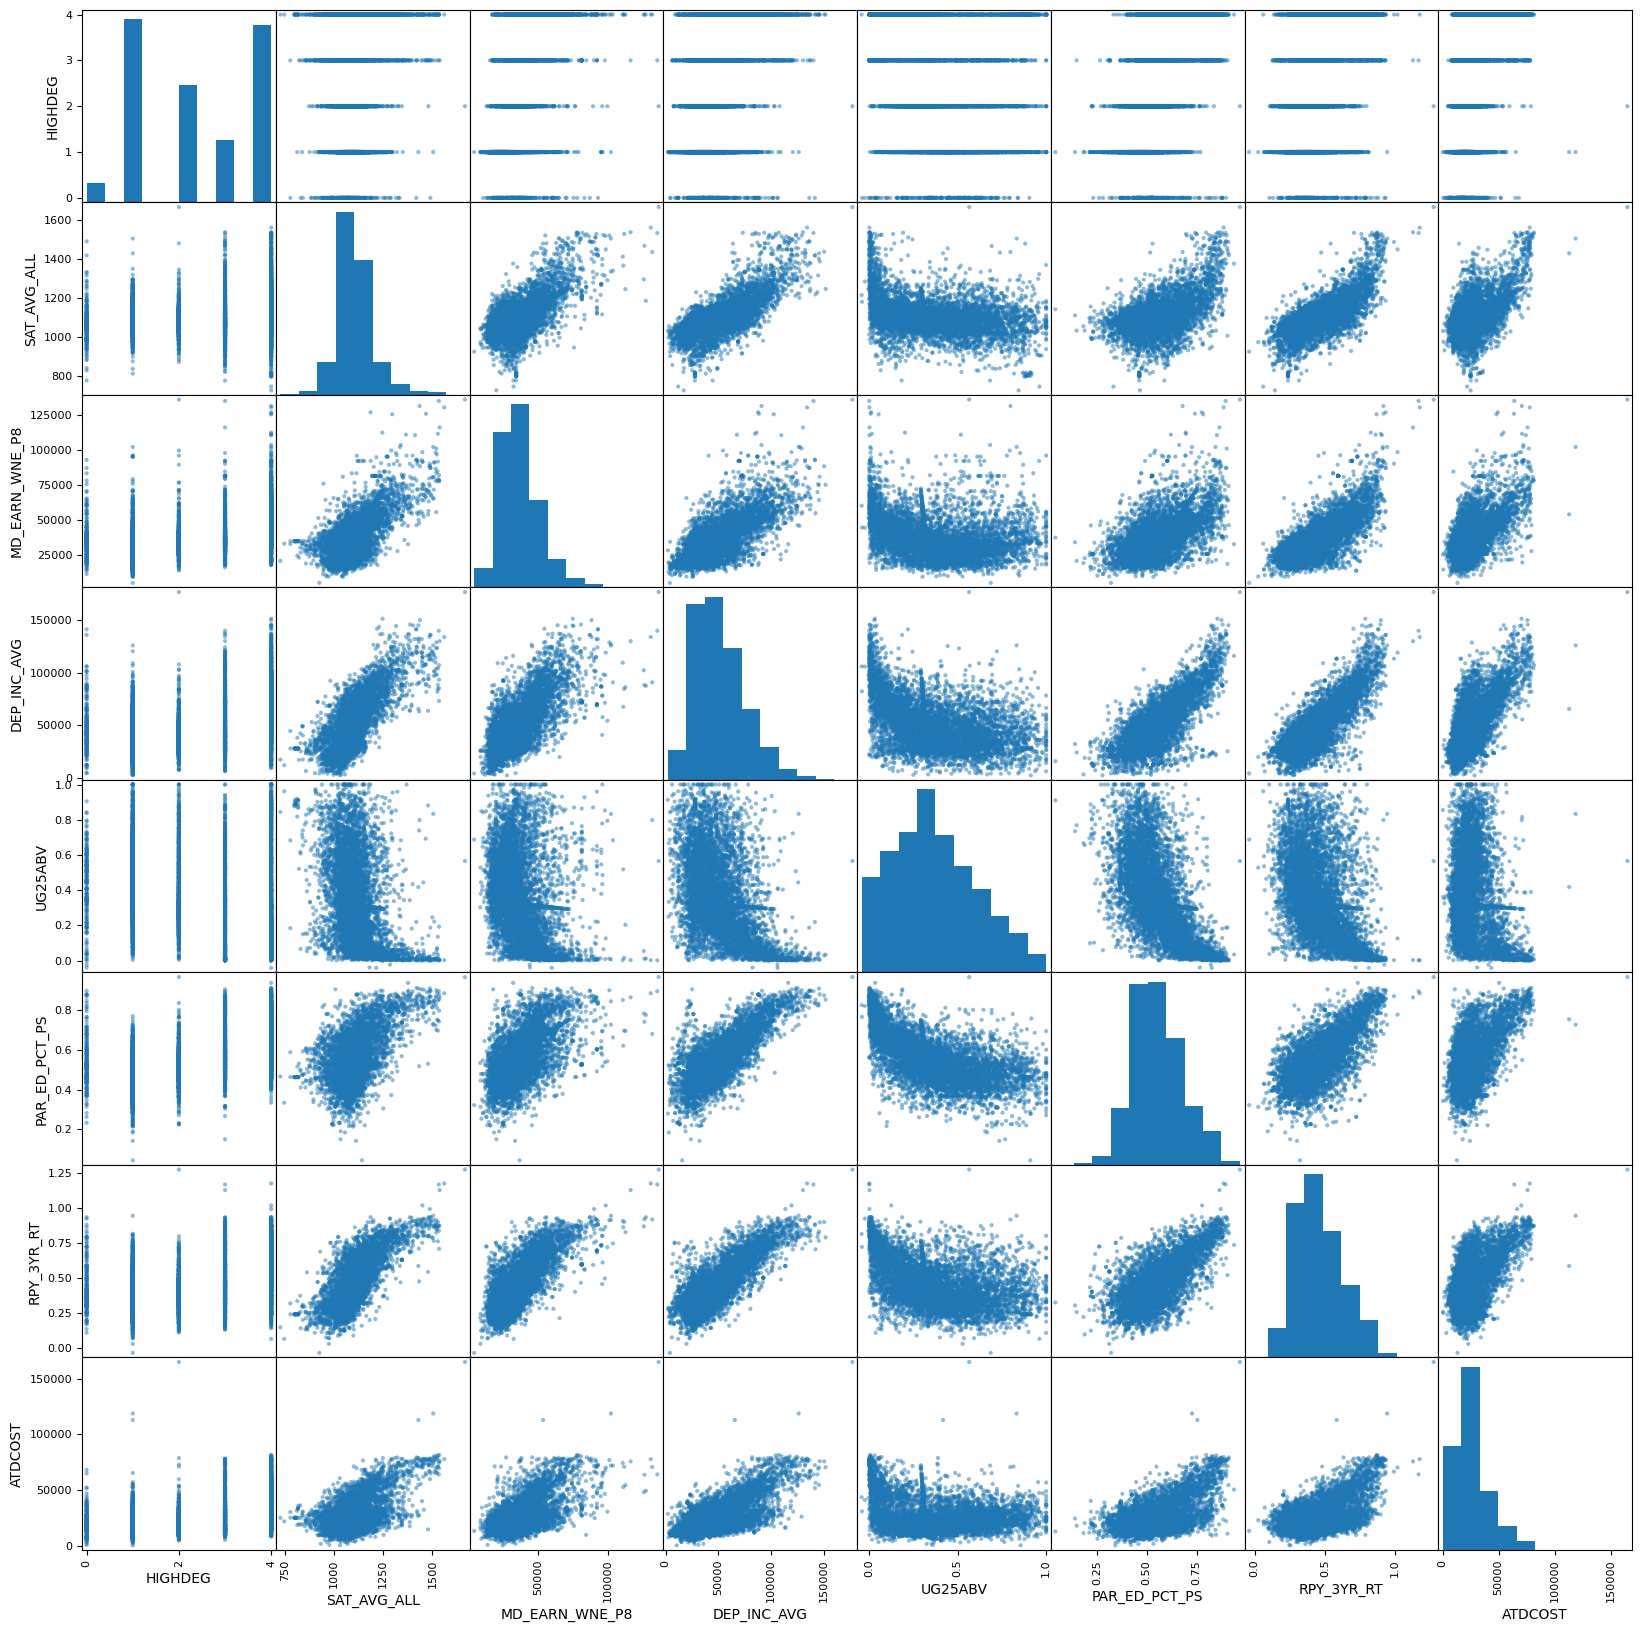

In [230]:
pd.plotting.scatter_matrix(df_final, figsize=(20,20))
plt.show()

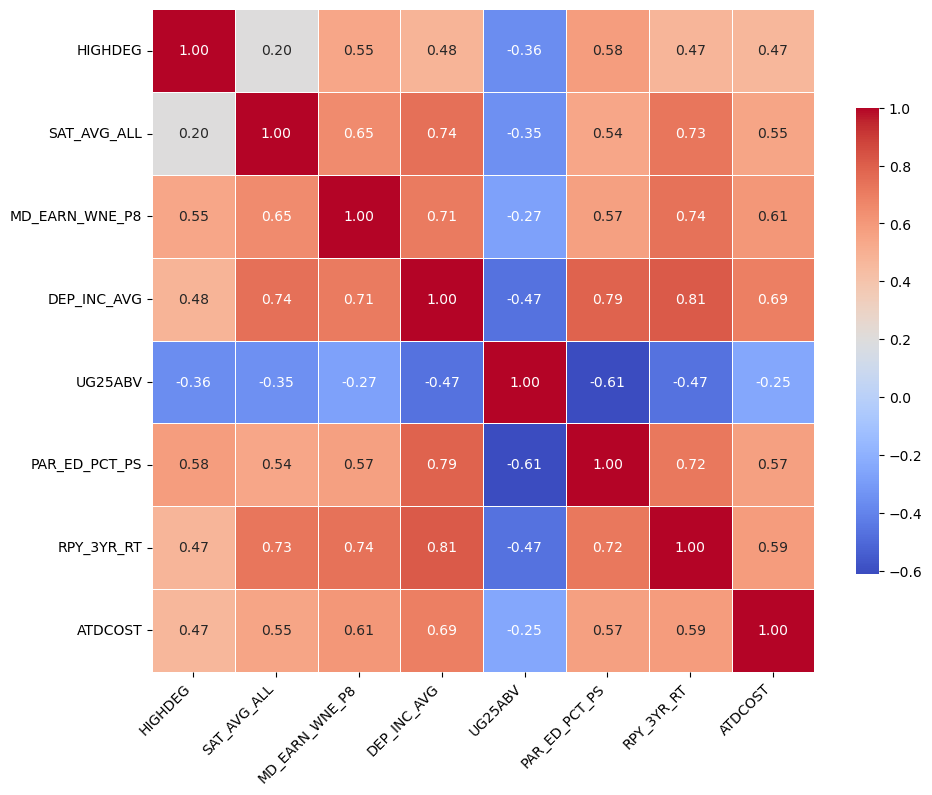

In [231]:
corr_final = df_final.corr()
plt.figure(figsize=(10, 10))

sns.heatmap(corr_final, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [240]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6217 entries, 0 to 6542
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HIGHDEG         6217 non-null   float64
 1   SAT_AVG_ALL     6217 non-null   float64
 2   MD_EARN_WNE_P8  6217 non-null   float64
 3   DEP_INC_AVG     6217 non-null   float64
 4   UG25ABV         6217 non-null   float64
 5   PAR_ED_PCT_PS   6217 non-null   float64
 6   RPY_3YR_RT      6217 non-null   float64
 7   ATDCOST         6217 non-null   float64
dtypes: float64(8)
memory usage: 437.1 KB


In [233]:
df_final.isnull().sum()

HIGHDEG           0
SAT_AVG_ALL       0
MD_EARN_WNE_P8    0
DEP_INC_AVG       0
UG25ABV           0
PAR_ED_PCT_PS     0
RPY_3YR_RT        0
ATDCOST           0
dtype: int64

In [234]:
csv_file_path = '/Users/veg/Desktop/df_final.csv'  
df.to_csv(csv_file_path, index=False)  